# We implement a Kalman Filter on a double integrator $\ddot{x} = a + v$ with GPS measurements $z = x + w$
We follow https://www.intechopen.com/books/introduction-and-implementations-of-the-kalman-filter/introduction-to-kalman-filter-and-its-applications section 2

\begin{align}
x_{k+1} = \pmatrix{ p_{k+1} \\ v_{k+1}} 
&= \pmatrix{ p_k + v_k \Delta t + \frac{1}{2} a_k \Delta t^2 \\ v_k + a_k \Delta t} \\
&= \pmatrix{ I_{3 \times 3} & I_{3 \times 3} \Delta t \\ 0 & I_{3 \times 3}} \pmatrix{ p_k \\ v_k} +
   \pmatrix{ \frac{1}{2} I_{3 \times 3} \Delta t^2 \\  I_{3 \times 3} \Delta t} a_k \\
&= Ax_k + Ba_k
\end{align}

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from estimation.filters import KalmanFilter
from dynamics.doubleintegrator import DoubleIntegrator
np.set_printoptions(suppress=True, precision=3)

In [3]:
# PARAMS
a_std = 0.3
p_std = 3
v_std = 0.03

x0 = np.array([2,-2,0,5,5.1,0.1])
P0 = np.block([[np.eye(3) * 4**2, np.zeros((3,3))],
               [np.zeros((3,3)), np.eye(3) * 0.4**2]])
dt = 1
N = 20

In [4]:
# Building the Kalman Filter
Q = np.block([[1/4 * dt**4 * np.eye(3), 1/2 * dt**3 * np.eye(3)],
              [1/2 * dt**3 * np.eye(3), dt**2 * np.eye(3)]])
R = a_std**2 *np.block([[np.eye(3) * p_std**2, np.zeros((3,3))],
                        [np.zeros((3,3)), np.eye(3) * v_std**2]])
A = np.block([[np.eye(3), np.eye(3)*dt],
              [np.zeros((3,3)), np.eye(3)]])
B = np.block([[1/2 * np.eye(3) * dt**2],
              [np.eye(3) * dt]])
C = np.eye(6)
kf = KalmanFilter(A,B,C,Q,R)

In [5]:
di = DoubleIntegrator(dim=3)
def u(t):
    return np.random.normal(0, a_std, 3)

x0 = [0,0,0,5,5,0]
t_span = (0,N)
sol = solve_ivp(lambda t,x: di.f(t,x,u(t)), t_span, x0, t_eval=np.arange(0,N,dt))

In [10]:
# KF prediction only
preds = np.zeros((N,6))
preds[0] = x0
x = x0; P = P0;
for i in range(1,20):
    x, P = kf.predict(x, P, np.zeros(3))
    preds[i] = x

In [14]:
# Generate noisy observations
x = sol.y
p_obs_noise = np.random.normal(0, p_std, (3,N))
v_obs_noise = np.random.normal(0, v_std, (3,N))
obs_noise = np.vstack([p_obs_noise, v_obs_noise])
obs = x + obs_noise

In [17]:
# KF with pred + update
filtered = np.zeros((N,6))
filtered[0] = x0
x = x0; P = P0;
for i in range(1,20):
    x, P = kf.predict(x, P, np.zeros(3))
    x, P = kf.update(x, P, obs.T[i])
    filtered[i] = x

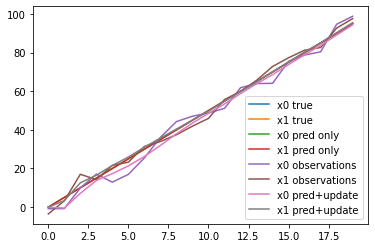

In [18]:
plt.plot(x[0], label="x0 true")
plt.plot(x[1], label="x1 true")
plt.plot(preds.T[0], label="x0 pred only")
plt.plot(preds.T[1], label="x1 pred only")
plt.plot(obs[0], label="x0 observations")
plt.plot(obs[1], label="x1 observations")
plt.plot(filtered.T[0], label="x0 pred+update")
plt.plot(filtered.T[1], label="x1 pred+update")
plt.legend()